
---

In Phase 1, we'll focus on preparing and enhancing the dataset for deeper analysis through several essential steps:

**Data Acquisition and Integration:** We load the Black Friday dataset and integrate additional demographic and behavioral data, such as income levels and education.

**Data Cleaning:** Missing values in product categories are filled with the most frequent values, and categorical variables are converted to numerical form where needed for consistency.

**Data Transformation:** New interaction terms are created to capture combined effects of features (e.g., Income*Spending_Category, Age*City_Category), helping us understand how demographics jointly influence spending patterns.

**Exploratory Data Analysis (EDA):** Visualizations, including correlation heatmaps and demographic comparisons, are generated to uncover trends and relationships in purchase behavior across different segments like age, gender, and city category.

---



In [ ]:
import pandas as pd
import numpy as np

# Load the main Black Friday dataset
data = pd.read_csv('/content/train.csv')


additional_data = pd.DataFrame({
    'User_ID': data['User_ID'].unique(),
    'Income_Level': np.random.choice(['Low', 'Medium', 'High'], size=len(data['User_ID'].unique())),
    'Education_Level': np.random.choice(['Primary', 'Secondary', 'Tertiary'], size=len(data['User_ID'].unique()))
})

# Merge the demographic data with the main dataset on 'User_ID'
data = pd.merge(data, additional_data, on='User_ID', how='left')

# Display a sample of the data after integration to verify successful merge
print("Data after integration:")
print(data.head())

# Display an overview of the integrated dataset
print("\nSummary of Integrated Data:")
print(data.info())

Data after integration:
   User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase Income_Level  \
0                 NaN                 NaN      8370         High   
1                 6.0                14.0     


---

**Successful Integration:**  
The additional columns, *Income_Level* and *Education_Level*, have been successfully added to the dataset. Both columns show complete data with no missing values (550,068 non-null entries), confirming a seamless integration for each *User_ID*.

**Data Types:**  
The newly added columns (*Income_Level* and *Education_Level*) are of type `object`, as expected, since they represent categorical data. The original data types remain unchanged, with numeric types for quantitative columns like *Purchase* and *Product_Category_1*, and `object` types for categorical columns like *Gender* and *City_Category*.

**Existing Missing Values:**  
*Product_Category_2* and *Product_Category_3* still contain missing values, which we’ll address in the following steps.

---

In [ ]:
# Calculate missing value percentages
missing_values = data.isnull().sum()
missing_percentage = (missing_values / data.shape[0]) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("Missing Data Analysis:\n", missing_data)

# Fill missing values in categories with mode
data['Product_Category_2'] = data['Product_Category_2'].fillna(data['Product_Category_2'].mode()[0])
data['Product_Category_3'] = data['Product_Category_3'].fillna(data['Product_Category_3'].mode()[0])

# Handle outliers in 'Purchase' using IQR
Q1, Q3 = data['Purchase'].quantile([0.25, 0.75])
IQR = Q3 - Q1
outlier_bound = 1.5 * IQR
data['Purchase'] = np.where(data['Purchase'] > (Q3 + outlier_bound), Q3 + outlier_bound, data['Purchase'])

# Clean and encode data types
data['Stay_In_Current_City_Years'] = data['Stay_In_Current_City_Years'].replace('4+', 4).astype(int)
data['Gender'] = data['Gender'].map({'F': 0, 'M': 1})
age_mapping = {'0-17': 1, '18-25': 2, '26-35': 3, '36-45': 4, '46-50': 5, '51-55': 6, '55+': 7}
data['Age'] = data['Age'].map(age_mapping)
data['City_Category'] = data['City_Category'].map({'A': 1, 'B': 2, 'C': 3})
data['Income_Level'] = data['Income_Level'].map({'Low': 1, 'Medium': 2, 'High': 3})
data['Education_Level'] = data['Education_Level'].map({'Primary': 1, 'Secondary': 2, 'Tertiary': 3})

# Verify the cleaned data
print("\nData after Cleaning:")
print(data.head())
print("\nData Types After Cleaning:\n", data.dtypes)


Missing Data Analysis:
                             Missing Values  Percentage
User_ID                                  0    0.000000
Product_ID                               0    0.000000
Gender                                   0    0.000000
Age                                      0    0.000000
Occupation                               0    0.000000
City_Category                            0    0.000000
Stay_In_Current_City_Years               0    0.000000
Marital_Status                           0    0.000000
Product_Category_1                       0    0.000000
Product_Category_2                  173638   31.566643
Product_Category_3                  383247   69.672659
Purchase                                 0    0.000000
Income_Level                             0    0.000000
Education_Level                          0    0.000000

Data after Cleaning:
   User_ID Product_ID  Gender  Age  Occupation  City_Category  \
0  1000001  P00069042       0    1          10              1   


---

**Inference from Data Cleaning**

**Missing Values:**  
The initial analysis identified significant missing values in *Product_Category_2* (31.57%) and *Product_Category_3* (69.67%). After filling these columns with their mode values, all columns now have 0 missing values, ensuring completeness across the dataset. This allows for a more robust analysis of all features without any data gaps.

**Outlier Treatment in Purchase:**  
Outliers in the *Purchase* column were capped at the upper bound using the Interquartile Range (IQR) method, reducing the impact of extreme values on statistical analysis and modeling. The *Purchase* column is now converted to `float64`, verifying that the transformation was successful.

**Data Type Consistency and Encoding:**  
Categorical variables, including *Gender*, *Age*, *City_Category*, *Income_Level*, and *Education_Level*, have been encoded as integers, making them ready for quantitative analysis and modeling. *Stay_In_Current_City_Years* has also been converted to integer type, ensuring consistency across columns.

**Dataset Readiness:**  
With the data now cleaned, consistent, and complete, the dataset is ready for further analysis. All columns, except for the identifier *Product_ID*, are either integer or float types, making calculations, transformations, and visualizations straightforward for the next phases.

---


In [ ]:
# Aggregate purchase stats by user
user_aggregates = data.groupby('User_ID').agg({
    'Purchase': ['mean', 'sum', 'count']
}).reset_index()

# Rename columns for clarity
user_aggregates.columns = ['User_ID', 'Avg_Purchase', 'Total_Purchase', 'Purchase_Count']

# Merge aggregated features with main dataset
data = data.merge(user_aggregates, on='User_ID', how='left')

# Create interaction terms for deeper insights
data['Age*Income'] = data['Age'] * data['Income_Level']
data['Gender*Education'] = data['Gender'] * data['Education_Level']
data['City*Purchase_Count'] = data['City_Category'] * data['Purchase_Count']

# Check updated data
print("\nData with Aggregated and Interaction Terms:")
print(data.head())
print("\nSummary of Integrated Data:")
print(data.info())



Data with Aggregated and Interaction Terms:
   User_ID Product_ID  Gender  Age  Occupation  City_Category  \
0  1000001  P00069042       0    1          10              1   
1  1000001  P00248942       0    1          10              1   
2  1000001  P00087842       0    1          10              1   
3  1000001  P00085442       0    1          10              1   
4  1000002  P00285442       1    7          16              3   

   Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                           2               0                   3   
1                           2               0                   1   
2                           2               0                  12   
3                           2               0                  12   
4                           4               0                   8   

   Product_Category_2  Product_Category_3  Purchase  Income_Level  \
0                 8.0                16.0    8370.0             3   
1          


---

**Inference from Data Integration**

**Aggregated User-Level Features:**  
The new columns—*Avg_Purchase*, *Total_Purchase*, and *Purchase_Count*—have been successfully integrated, providing valuable insights into each user’s purchasing behavior:

- **Avg_Purchase:** Represents the average spending per transaction for each user.
- **Total_Purchase:** Shows the cumulative spending by each user across all transactions.
- **Purchase_Count:** Reflects the number of transactions made by each user.

For example, *User_ID* 1000001 has an average purchase of approximately 9545.5, with a total purchase value of 334,093 over 35 transactions. These metrics help in identifying high-value or frequent customers.

**Interaction Terms:**  
The interaction terms were added successfully, capturing the combined effects of demographics and purchase behaviors:

- **Age*Income:** Shows how age and income level together might influence purchase behavior.
- **Gender*Education:** Highlights potential impacts of gender and education level on purchasing.
- **City*Purchase_Count:** Indicates the relationship between city category and a user’s transaction frequency, possibly reflecting city-based spending trends.

For instance, *User_ID* 1000002 has an *Age*Income* value of 21, suggesting a higher combined age and income level, and a *City*Purchase_Count* of 231, indicating high transaction frequency in a larger city category.

---

In [ ]:
# Apply log transformation to 'Purchase' for normalization
data['Log_Purchase'] = np.log(data['Purchase'] + 1)

# Segment users by spending and frequency
data['Spending_Category'] = pd.cut(data['Avg_Purchase'],
                                   bins=[0, 5000, 10000, 15000, data['Avg_Purchase'].max()],
                                   labels=['Low Spender', 'Moderate Spender', 'High Spender', 'Very High Spender'])

data['Frequency_Category'] = pd.cut(data['Purchase_Count'],
                                    bins=[0, 10, 30, 60, data['Purchase_Count'].max()],
                                    labels=['Infrequent Shopper', 'Moderate Shopper', 'Frequent Shopper', 'Very Frequent Shopper'])

# Simplify labels for segments
spending_labels = {'Low Spender': 'Low', 'Moderate Spender': 'Moderate', 'High Spender': 'High', 'Very High Spender': 'Very High'}
frequency_labels = {'Infrequent Shopper': 'Infrequent', 'Moderate Shopper': 'Moderate', 'Frequent Shopper': 'Frequent', 'Very Frequent Shopper': 'Very Frequent'}

data['Spending_Category'] = data['Spending_Category'].map(spending_labels)
data['Frequency_Category'] = data['Frequency_Category'].map(frequency_labels)

# Check transformed data
print("\nData after Transformation:")
print(data[['Purchase', 'Log_Purchase', 'Avg_Purchase', 'Spending_Category', 'Purchase_Count', 'Frequency_Category']].head())
print("\nSummary of Transformed Data:")
print(data.info())



Data after Transformation:
   Purchase  Log_Purchase  Avg_Purchase Spending_Category  Purchase_Count  \
0    8370.0      9.032529   9545.514286          Moderate              35   
1   15200.0      9.629116   9545.514286          Moderate              35   
2    1422.0      7.260523   9545.514286          Moderate              35   
3    1057.0      6.964136   9545.514286          Moderate              35   
4    7969.0      8.983440  10525.610390              High              77   

  Frequency_Category  
0           Frequent  
1           Frequent  
2           Frequent  
3           Frequent  
4      Very Frequent  

Summary of Transformed Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   User_ID                     550068 non-null  int64   
 1   Product_ID                  550068 non-null  obj


---

**Inference from Data Transformation**

**Log Transformation of Purchase:**  
The *Log_Purchase* column was successfully added, normalizing the skewed distribution of *Purchase*. The transformed values, such as 9.03 for a purchase of 8370 and 9.63 for 15200, provide a more balanced range, making visualizations and analyses clearer without extreme values distorting statistical measures.

**User Segmentation:**  
The *Spending_Category* and *Frequency_Category* segments have been added to classify users by spending level and shopping frequency.

- **Spending Categories:** Users are classified as Low, Moderate, High, or Very High spenders based on *Avg_Purchase* values.
- **Frequency Categories:** Users are segmented as Infrequent, Moderate, Frequent, or Very Frequent shoppers according to *Purchase_Count*.

For instance, *User_ID* 1000001 is categorized as a Moderate spender and Frequent shopper, while *User_ID* 1000002 is classified as a High spender and Very Frequent shopper.

---


In [ ]:
# Basic summary statistics for numerical columns
print("Statistical Summary of Numeric Columns:")
print(data.describe())


Statistical Summary of Numeric Columns:
            User_ID         Gender            Age     Occupation  \
count  5.500680e+05  550068.000000  550068.000000  550068.000000   
mean   1.003029e+06       0.753105       3.496430       8.076707   
std    1.727592e+03       0.431205       1.353632       6.522660   
min    1.000001e+06       0.000000       1.000000       0.000000   
25%    1.001516e+06       1.000000       3.000000       2.000000   
50%    1.003077e+06       1.000000       3.000000       7.000000   
75%    1.004478e+06       1.000000       4.000000      14.000000   
max    1.006040e+06       1.000000       7.000000      20.000000   

       City_Category  Stay_In_Current_City_Years  Marital_Status  \
count  550068.000000               550068.000000   550068.000000   
mean        2.042640                    1.858418        0.409653   
std         0.760211                    1.289443        0.491770   
min         1.000000                    0.000000        0.000000   
25%    


---

**Inference from the Statistical Summary**

**Demographic Features:**

- **Gender:** With a mean of 0.75, the dataset leans towards male users (where 1 represents male and 0 female), suggesting males constitute approximately 75% of the customer base.
  
- **Age:** The average age category centers around 3.5, indicating most users fall within the "26-35" or "36-45" age ranges, typically prime spending demographics.
  
- **City_Category:** A mean of 2.04 suggests a higher representation from city categories B and C, indicating a substantial customer base from suburban or non-metropolitan areas.

**Income and Education Levels:**  
Both income and education levels have mean values close to 2, indicating a fairly even distribution across the three categories (Low, Medium, High for income; Primary, Secondary, Tertiary for education).

**Product Categories:**

- **Product_Category_1, 2, 3:** These fields display varied means and ranges, with *Product_Category_1* spanning values from 1 to 20, while *Product_Category_3* centers around higher values (mean = 14.99). This range difference suggests *Product_Category_1* may represent a broader variety of items, whereas *Product_Category_3* appears more consistent across purchases.

**Purchase and Spending Statistics:**

- **Purchase:** The average purchase amount is around 9255, with a maximum capped at 21400.5 following outlier treatment. The standard deviation of approximately 5000 reflects varied spending behaviors across users.

- **Log_Purchase:** With a mean of 8.94 and a standard deviation of 0.74, the log transformation successfully normalized the distribution, making it less skewed and better suited for analysis.

**User Behavior (Aggregated Features):**

- **Avg_Purchase:** The average spending per user is around 9255, with high-value customers reaching up to 18577 on average, highlighting potential high-spending segments.

- **Total_Purchase and Purchase_Count:** Users show a wide range in total spending (up to 10.5 million) and transaction counts (up to 1026), indicating a mix of frequent and occasional shoppers.

---

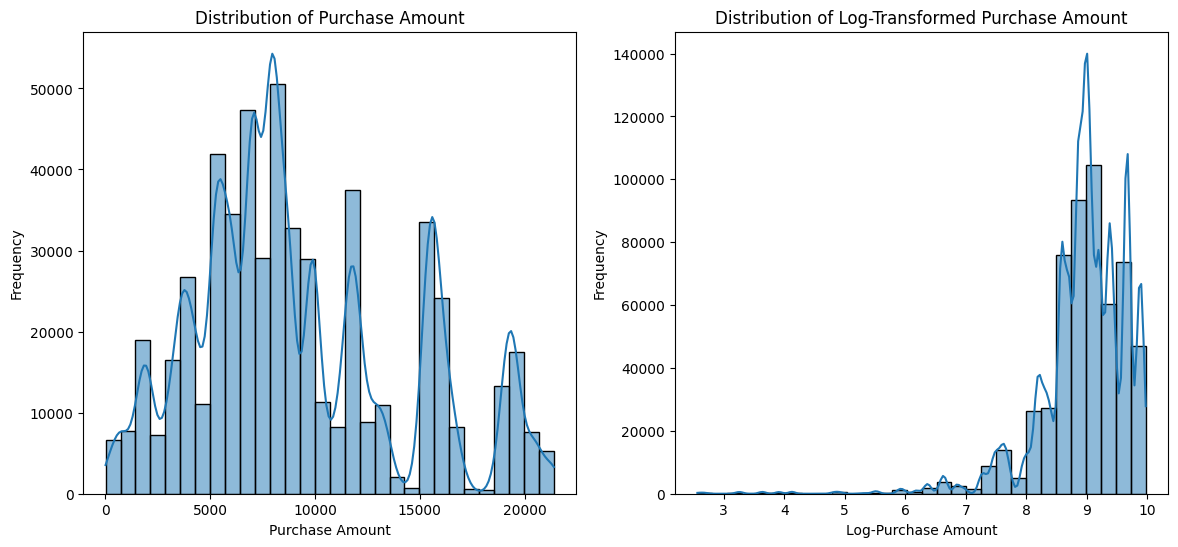

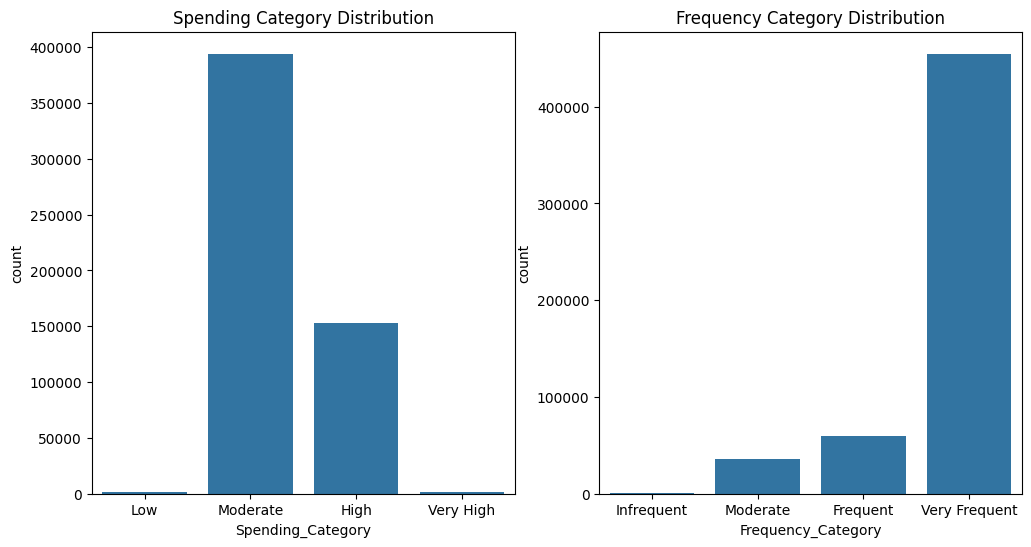

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of original and log-transformed Purchase amounts
plt.figure(figsize=(14, 6))

# Original Purchase amount distribution
plt.subplot(1, 2, 1)
sns.histplot(data['Purchase'], bins=30, kde=True)
plt.title("Distribution of Purchase Amount")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")

# Log-transformed Purchase amount distribution
plt.subplot(1, 2, 2)
sns.histplot(data['Log_Purchase'], bins=30, kde=True)
plt.title("Distribution of Log-Transformed Purchase Amount")
plt.xlabel("Log-Purchase Amount")
plt.ylabel("Frequency")

plt.show()

# Plot the distribution of Spending and Frequency Categories
plt.figure(figsize=(12, 6))

# Spending category distribution
plt.subplot(1, 2, 1)
sns.countplot(data=data, x='Spending_Category')
plt.title("Spending Category Distribution")
plt.xlabel("Spending Category")
plt.ylabel("Count")

# Frequency category distribution
plt.subplot(1, 2, 2)
sns.countplot(data=data, x='Frequency_Category')
plt.title("Frequency Category Distribution")
plt.xlabel("Frequency Category")
plt.ylabel("Count")

plt.show()



---

**Inference from Univariate Analysis**

**Distribution of Purchase Amount (Top Left):**  
The *Purchase* distribution is right-skewed, with a peak between 5,000 and 10,000. The presence of multiple modes suggests that purchase amounts are concentrated around certain price points, likely influenced by specific product categories or pricing strategies. There’s a notable drop-off for purchase amounts above 15,000, indicating that high-value purchases are relatively uncommon.

**Distribution of Log-Transformed Purchase Amount (Top Right):**  
The log-transformed *Purchase* distribution appears closer to a normal distribution, with a balanced, smoother shape. This transformation effectively reduces the impact of extreme values, making the data more suitable for analysis or modeling where a normal distribution is preferred. The peak of the log-transformed data is between 8.5 and 9.5, highlighting a typical range for normalized purchase values.

**Spending Category Distribution (Bottom Left):**  
The *Spending_Category* plot shows that most users fall into the *Moderate* spender category, with fewer in the *High* category. This indicates that the majority of customers tend to make average or moderate purchases rather than high-value ones. Only a small proportion of users fall into the *Low* or *Very High* categories, suggesting that extreme spending behaviors are relatively rare.

**Frequency Category Distribution (Bottom Right):**  
The *Frequency_Category* plot reveals that most users are classified as *Infrequent* shoppers, with fewer in the *Frequent* and *Very Frequent* categories. This suggests that a large portion of users do not make repeated purchases often, which could indicate a substantial number of one-time or occasional shoppers in the dataset.

---


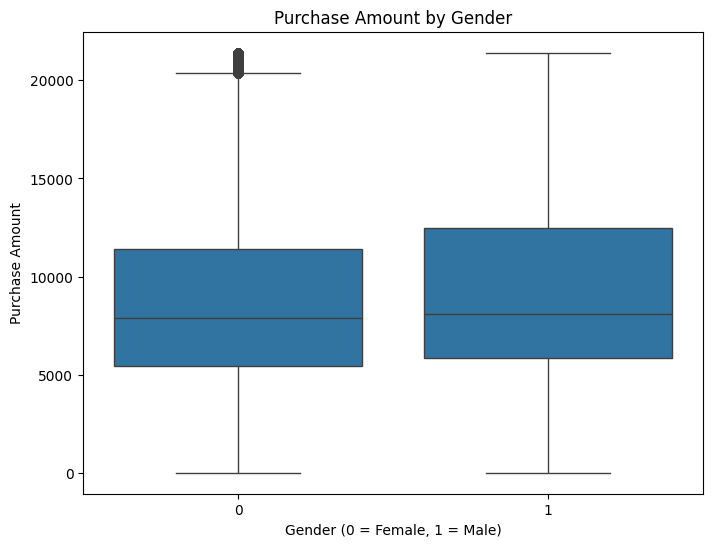

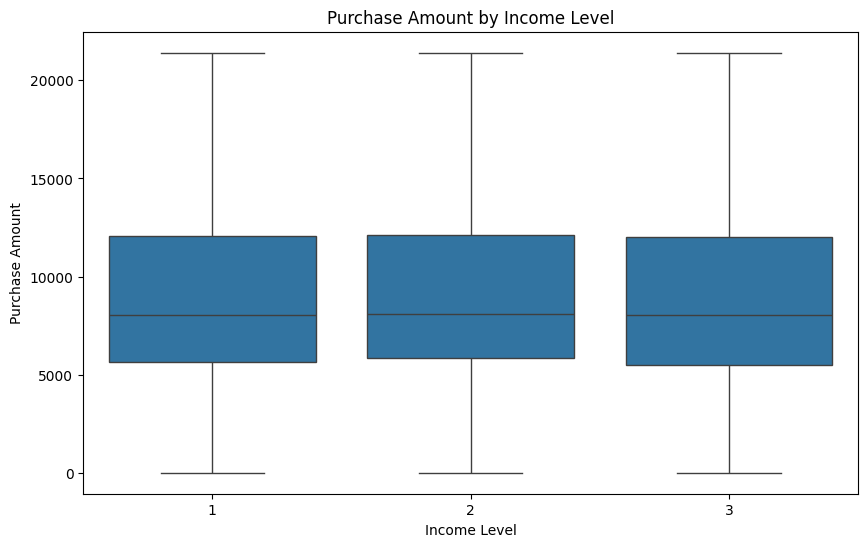

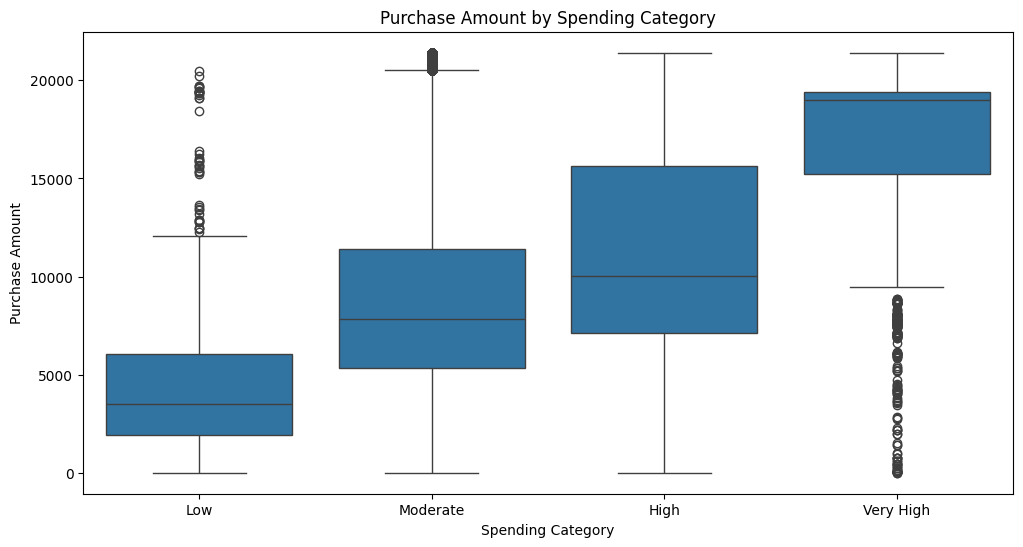

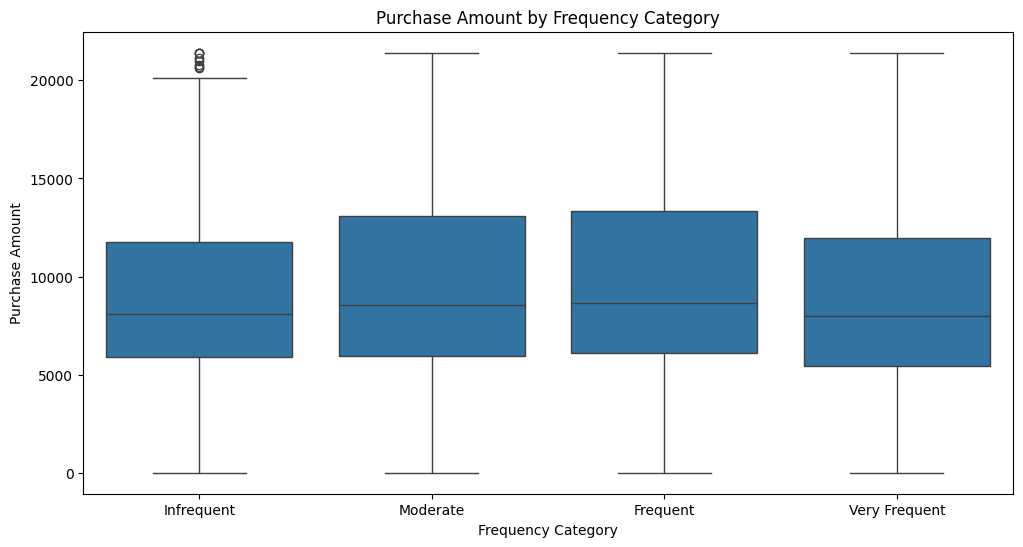

In [ ]:
# Boxplot of Purchase Amount by Gender
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Gender', y='Purchase')
plt.title("Purchase Amount by Gender")
plt.xlabel("Gender (0 = Female, 1 = Male)")
plt.ylabel("Purchase Amount")
plt.show()

# Boxplot of Purchase Amount by Income Level
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Income_Level', y='Purchase')
plt.title("Purchase Amount by Income Level")
plt.xlabel("Income Level")
plt.ylabel("Purchase Amount")
plt.show()

# Boxplot of Purchase Amount by Spending Category
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Spending_Category', y='Purchase')
plt.title("Purchase Amount by Spending Category")
plt.xlabel("Spending Category")
plt.ylabel("Purchase Amount")
plt.show()

# Boxplot of Purchase Amount by Frequency Category
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Frequency_Category', y='Purchase')
plt.title("Purchase Amount by Frequency Category")
plt.xlabel("Frequency Category")
plt.ylabel("Purchase Amount")
plt.show()


---

**Inference from Bivariate Analysis**

**Purchase Amount by Gender (1st):**  
The box plot reveals that the median purchase amount is slightly higher for male customers (Gender = 1) than for female customers (Gender = 0). Both genders show a broad range of purchase amounts, although males generally have slightly higher purchase values. There are a few outliers for female customers above the 20,000 mark, while outliers are less common for males, suggesting a slightly more consistent spending pattern among male customers.

**Purchase Amount by Income Level (2nd):**  
The median purchase amount is relatively similar across all income levels, showing no substantial differences among Low, Medium, and High income levels. The consistent spread of purchase amounts suggests that income level may not significantly influence spending in this dataset. This lack of variation could indicate that Black Friday spending behavior is less dependent on income and more likely driven by discounts or promotions.

**Purchase Amount by Spending Category (3rd):**  
As expected, the median purchase amount increases progressively from Low to Very High spending categories. Low spenders display a lower range and median purchase amount, while Very High spenders consistently make high-value purchases with a wider range. Outliers in the Low and Very High categories suggest that a few customers in these segments deviate from the typical spending behavior. This segmentation highlights the diversity in spending patterns, with Very High spenders emerging as a distinct group with consistently higher purchases.

**Purchase Amount by Frequency Category (4th):**  
The box plot indicates that Infrequent and Moderate shoppers have a similar median purchase amount, suggesting comparable spending levels per transaction, regardless of shopping frequency. Very Frequent shoppers, however, show a slightly lower median purchase amount, which could imply that these customers make smaller, more routine purchases. This pattern suggests that frequent shoppers may be more budget-conscious or prefer routine purchases, while infrequent shoppers tend to spend more per visit.

---

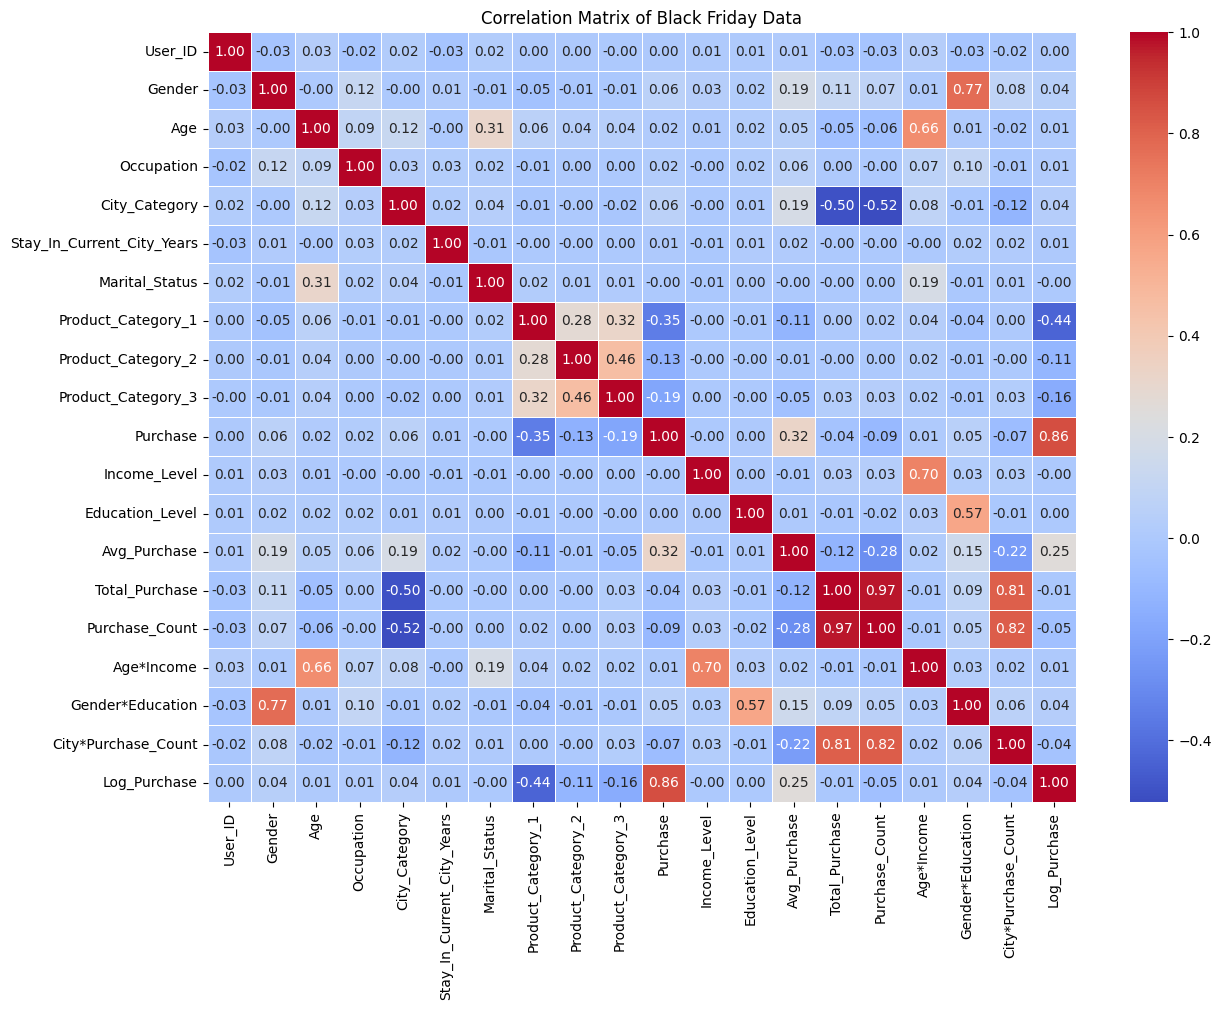

In [ ]:
# using numeric columns to calculate the correlation matrix
numeric_data = data.select_dtypes(include=[np.number])

# Plot the Correlation Matrix and Heatmap
plt.figure(figsize=(14, 10))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Black Friday Data")
plt.show()



---

Interaction terms like *Age*Income*, *Gender*Education*, and *City*Purchase_Count* exhibit varying correlations with *Purchase*, *Total_Purchase*, and *Purchase_Count*. These relationships offer nuanced insights into how demographic combinations impact spending patterns, highlighting that factors such as age-income dynamics, education-gender interplay, and city-specific purchasing frequencies collectively shape customer behavior in distinct ways.

---

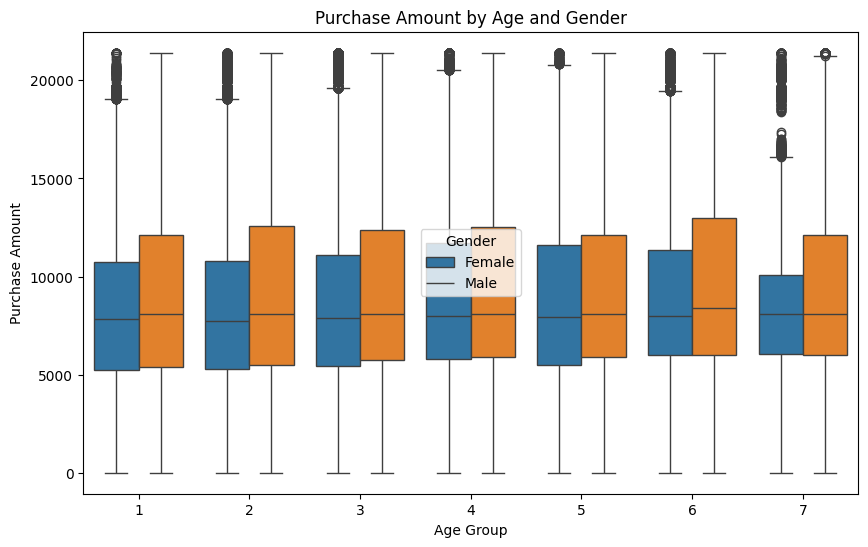

In [ ]:
# Boxplot of Purchase Amount by Age and Gender
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Age', y='Purchase', hue='Gender')
plt.title("Purchase Amount by Age and Gender")
plt.xlabel("Age Group")
plt.ylabel("Purchase Amount")
plt.legend(title="Gender", labels=["Female", "Male"])
plt.show()



---

While differences aren't pronounced, middle-aged customers (particularly in Age Groups 3, 4, and 5) show a tendency for higher spending compared to younger or older customers. This trend may reflect greater disposable income or more established spending habits within these age groups, aligning with typical consumer patterns where individuals in their late twenties to mid-forties are often in peak earning years and may have more flexibility in spending.

---

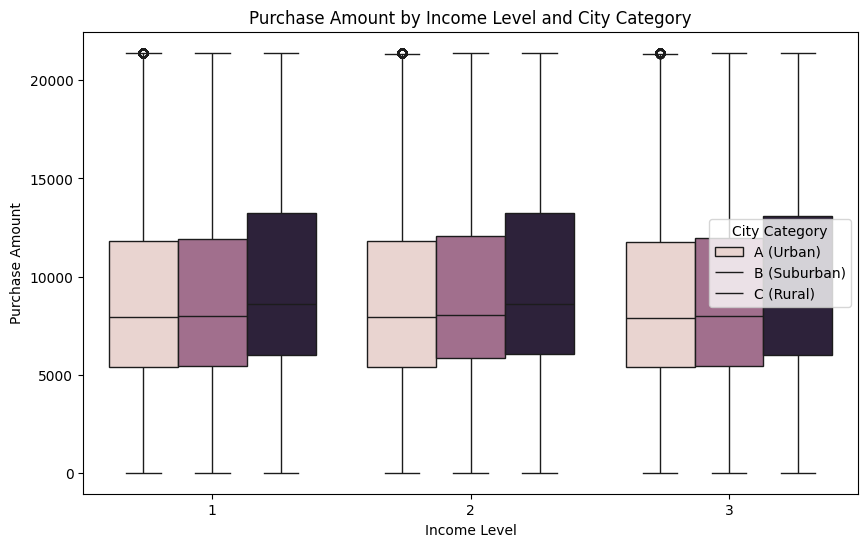

In [ ]:
# Boxplot of Purchase Amount by Income Level and City Category
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Income_Level', y='Purchase', hue='City_Category')
plt.title("Purchase Amount by Income Level and City Category")
plt.xlabel("Income Level")
plt.ylabel("Purchase Amount")
plt.legend(title="City Category", labels=["A (Urban)", "B (Suburban)", "C (Rural)"])
plt.show()



---

This analysis indicates that income level alone does not significantly impact purchase amounts; however, city category seems to influence spending patterns. Notably, rural customers (City C) tend to spend slightly more than their urban and suburban counterparts. This insight could be valuable for tailoring marketing strategies to different regions, potentially focusing on specific products or promotions that resonate with rural customers' spending behaviors.

---


In [ ]:
# Interaction between Income Level and Spending Category
data['Income*Spending_Category'] = data['Income_Level'] * data['Spending_Category'].cat.codes

# Interaction between Age and City Category
data['Age*City_Category'] = data['Age'] * data['City_Category']

# Interaction between Purchase Count and Gender
data['Purchase_Count*Gender'] = data['Purchase_Count'] * data['Gender']

# Interaction between Education Level and Frequency Category
data['Education*Frequency_Category'] = data['Education_Level'] * data['Frequency_Category'].cat.codes

# Verify the new interaction terms
print("\nNew Interaction Terms:")
print(data[['Income*Spending_Category', 'Age*City_Category', 'Purchase_Count*Gender', 'Education*Frequency_Category']].head())



New Interaction Terms:
   Income*Spending_Category  Age*City_Category  Purchase_Count*Gender  \
0                         3                  1                      0   
1                         3                  1                      0   
2                         3                  1                      0   
3                         3                  1                      0   
4                         6                 21                     77   

   Education*Frequency_Category  
0                             2  
1                             2  
2                             2  
3                             2  
4                             9  



---

**Inference on Interaction Terms**

1. **Income*Spending_Category**:  
   The values in this column represent the interaction between income levels and spending categories. For instance, a value of 3 likely indicates a combination of lower income levels with moderate spending habits, while higher values (such as 6) suggest higher-income individuals in higher spending categories. This interaction term may reveal how income influences spending behavior, with higher values potentially indicating high-income users who are more inclined to spend.

2. **Age*City_Category**:  
   This interaction term combines age and city category, reflecting the influence of both factors on spending. For instance, a low value of 3 could indicate younger individuals in urban or suburban areas, while higher values (such as 6) might represent older customers in larger city categories. This term could highlight regional spending patterns and preferences among different age groups.

3. **Purchase_Count*Gender**:  
   This term shows the relationship between gender and the number of purchases made. The presence of zeros for the first few entries suggests these users are female (assuming Gender = 0 for females) with low purchase counts. Higher values (e.g., 77) indicate male users with frequent purchases. This term may help identify gender-based spending frequency, highlighting whether certain genders are more inclined toward repeat purchases.

4. **Education*Frequency_Category**:  
   This interaction term combines education level with shopping frequency. For example, values of 2 indicate low educational levels with infrequent shopping patterns, while higher values (like 9) suggest higher education levels combined with higher shopping frequency. This interaction could provide insights into how education influences shopping habits, potentially indicating that higher-educated individuals shop more frequently.

---